In [1]:
import numpy as np
import scipy as sp
from scipy.stats import poisson, gamma
from scipy.special import gammaln as log_G, gamma as G, factorial as fac, logsumexp
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(12,8)


# Radioactive decay

We will be investigating the measurment of the intensity of a radioactive source in the presence of the background nose. 

## The model

The number of registered counts follows the Poisson distribution. For the background it is given by

$$P(k|\lambda_{b}) = e^{-\lambda_{b}}\frac{\lambda_{b}^k }{k!}$$

Where $\lambda_b$ is the background intensity and $t$ is the length of the measurment period. In the following we will set $t=1s$. 

In [2]:
data_b = np.loadtxt('data_b.txt')

In [3]:
data_b

array([31., 33., 29., 39., 26., 21., 35., 34., 33., 35., 35., 21., 38.,
       25., 36.])

In [4]:
data_b.mean()

31.4

For source and background this given by 
$$P(k|\lambda_{b}, \lambda_{s}) = e^{-(\lambda_{b}+\lambda_{s})t}\frac{(\lambda_{b}+\lambda_s)^k t^k}{k!}$$


In [5]:
data_b_s = np.loadtxt('data_b_s.txt')

In [6]:
data_b_s

array([43., 43., 43., 51., 45., 37., 38., 48., 34., 41.])

In [7]:
data_b_s.mean()

42.3

## Problem 1

### 1.

Write the formula for the  likelihood for the  background intensity measurments $k_1,\ldots,k_{n_b}$. Assuming [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution) distribution $\Gamma(\alpha, \beta)$ for $\lambda_b$ prior, write down  the formula for posterior distribution and MAP estimate of $\lambda_b$. __Hint__ Gamma distribution is a conjugate prior to Poisson distribution. 

$$P((k_{1},...,k_{{n}_{b}}) |\lambda_{b}) = P(k_{1}|\lambda_{b}) \times P(k_{2}|\lambda_{b}) \times ... \times P(k_{{n}_{b}}|\lambda_{b}) $$

$$P((k_{1},...,k_{{n}_{b}}) |\lambda_{b}) = \prod_{i=1}^{n_{b}} P((k_{1},...,k_{{i}_{b}}) |\lambda_{b}) =  \prod_{i=1}^{n_{b}} \lambda_{b}^{k_{{i}}}\frac{e^{-\lambda_{b}}}{k_{i}!} \propto \lambda_{b}^{\sum_{i=1}^{n_{b}}k_{{i}}} e^{-n_{b}\lambda_{b}} $$

Posterior

$$P(\lambda_{b}|(k_{1},...,k_{{n}_{b}})) = \lambda_{b}^{\alpha+{\sum_{i=1}^{n_{b}}k_{{i}}}-1} e^{-(\beta + n_{b})\lambda_{b}}$$

This is again Gamma distribution (conjugate prior!) but with  different parameters: $\Gamma(\alpha+K, \beta+n_b)$. From [Wikipedia](https://en.wikipedia.org/wiki/Gamma_distributio) :) we find that the mode of $\Gamma(\alpha,\beta)$ distribution is $\frac{\alpha-1}{\beta}$ provided $\alpha\ge 1$. So finally MAP estimate is given by

$$\frac {\alpha + \sum_{i=1}^{n_{b}}k_{{i}} - 1}{\beta + n_{b}}$$

### 2.

Express $\alpha$ and $\beta$ by mean $\mu$ and standard deviation $\sigma$ of the distribution $\Gamma(\alpha,\beta)$. 

$$ \alpha = \frac {\mu^{2}}{\sigma^{2}}; \beta = \frac {\mu}{\sigma^{2}}$$

Assuming $\mu=50$ and $\sigma=70$ plot the prior and posterior distribution using provided background data and calculate the $\lambda_b$ MAP estimate. __Hint__ Use Gamma distribution from `scipy.stats`.

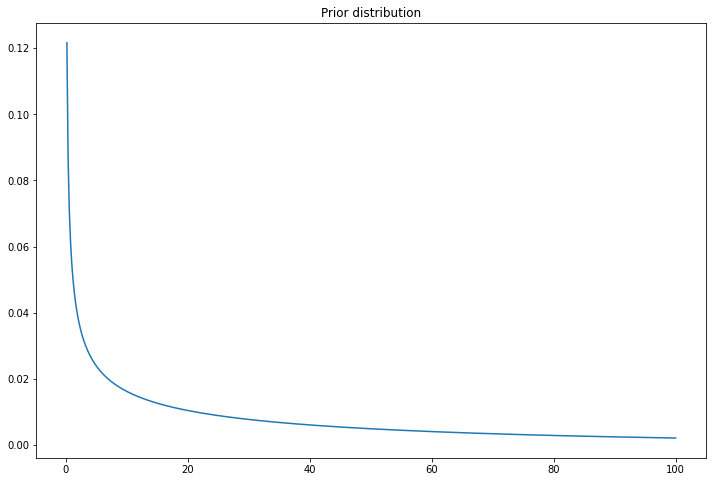

In [8]:
alpha = pow(50 / 70, 2)
beta = (50 / pow(70, 2))

ls = np.linspace(0, 100, 500)

plt.title("Prior distribution")
plt.plot(ls, gamma(a = alpha, scale = 1 / beta).pdf(ls))

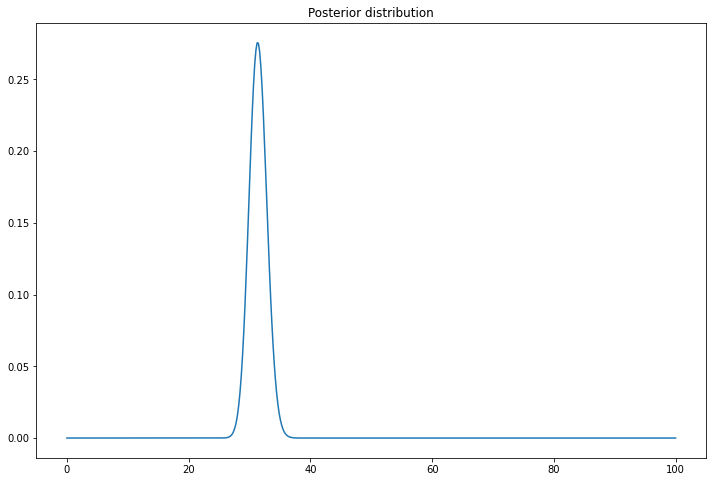

In [9]:
plt.title("Posterior distribution")
plt.plot(ls, gamma(a = alpha + sum(data_b), scale = 1 / (beta + len(data_b))).pdf(ls))

In [10]:
print('MAP: ', (alpha + sum(data_b) - 1) / (beta + len(data_b)))

MAP:  31.34602311352821


## Problem 2

### 1

Write the formula for the  likelihood for the  background intensity measurments $k_1,\ldots,k_{n_b}$. Assuming a uniform distribution in the interval $(0,\lambda_{b,max}]$ for the $\lambda_b$ prior, write down  the formula for MAP estimate of $\lambda_b$.

$$ L = \log(\prod_{i=1}^{n_{b}} e^{-\lambda_{b}} \frac{\lambda^{{k}_{i}}_{b}}{k_{i}!}) = -n_{b}\lambda_{b} + \log (\lambda_{b}) \sum_{i=1}^{n_{b}}k_{{i}} - \sum_{i=1}^{n_{b}} \log(k_{i}!)$$

MAP


$$ \frac {\sum_{i=1}^{n_{b}}k_{{i}}}{n_{b}}

Assuming $\lambda_{b,max}=100.0$ calculate the MAP estimate using all the measurments. What would happen if $\lambda_{b,max}=20.0$ ?

In [11]:
def log_like(data, l):
    log_like = -len(data) * l + data.sum() * np.log(l)
    return log_like - log_like.max()

MAP:  31.462994388777553
MAP lambda = 20:  20.0


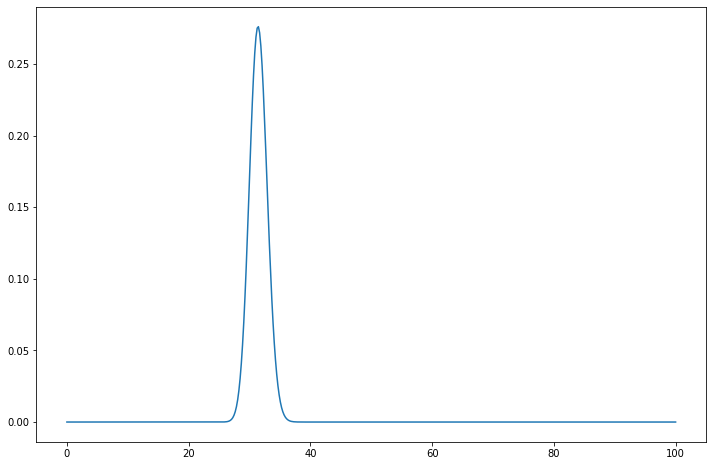

In [12]:
ls = np.linspace(0.0001, 100, 500)
P = np.exp(log_like(data_b, ls))
Z = P.sum() * 100 / 500
P /= Z

plt.plot(ls, P)

# print('MAP: ', data_b.sum()/len(data_b)) # 31.4
print('MAP: ', ls[np.argmax(log_like(data_b, ls))])
ls_twenty = np.linspace(0.0001, 20, 500)
print('MAP lambda = 20: ', ls_twenty[np.argmax(log_like(data_b, ls_twenty))])

### 2

Implement the formula for likelihood and then for posterior distribution of $\lambda_b$.  Plot the posterior distribution for $\lambda_b$ using 1,2,5,10 and 15 measurments. Use numerical integration for normalization. __Hint__ Use the log-likelihood to deal with numerical issues. 

In [13]:
def log_posterior(ls, prior_ls, kb):
    like = log_like(kb, ls) * prior_ls
    like -= like.max()
    like -= np.log(np.sum(np.exp(like)))
    return like

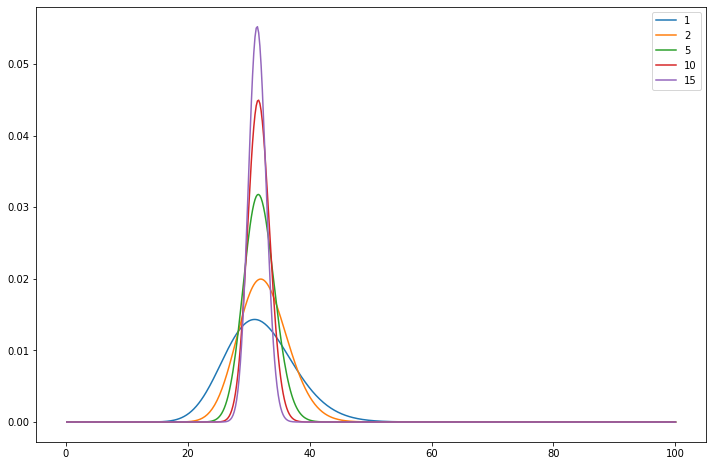

In [14]:
ls = np.linspace(0, 100, 500)[1:]
lambda_values = (1, 2, 5, 10, 15)
posts_dist = []
for n in lambda_values:
    exp_posterior = np.exp(log_posterior(ls, 1, data_b[:n]))
    posts_dist.append(exp_posterior)
    plt.plot(ls, exp_posterior, label = str(n))
plt.legend();

### 3

Calculate the mean and standard deviation of each posterior distribution plotted.

In [15]:
for n in lambda_values:
    exp_posterior = np.exp(log_posterior(ls, 1, data_b[:n]))
    mean = np.sum(exp_posterior / np.sum(exp_posterior) * ls)
    std = np.sqrt(np.sum(pow(ls - mean, 2) * exp_posterior / np.sum(exp_posterior)))
    print('Mean: ', mean, 'Standard deviation: ', std)

Mean:  31.999999999999964 Standard deviation:  5.656854249492125
Mean:  32.5 Standard deviation:  4.031128874149276
Mean:  31.799999999999997 Standard deviation:  2.5219040425837087
Mean:  31.700000000000003 Standard deviation:  1.7804493814764988
Mean:  31.46666666666667 Standard deviation:  1.4483707321600414


## Problem 3

Implement the log-likelihood for $\lambda_b$ and $\lambda_s$ using source plus background data. Then implement the log-posterior for those variables. Use the posterior from the previous problem as $\lambda_b$ prior (using all the data). Use the uniform distribution on $(0,100)$ for $\lambda_s$ prior. Plot the resulting two dimensional function and find the MAP estimates for $\lambda_b$ and $\lambda_s$ for 1,2,3 and 10 measurments of signal and background. 

How will the estimates change if a friend tells us that he is sure that the source activity is less then 15?